# Clothing Trade Network Creation

## Reading in and cleaning data

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
import os

In [2]:
# Define the folder containing your files
folder_path = 'trade_data'

# Initialize an empty list to store dataframes
dfs = []

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.dta'):  # Adjust this condition based on your file types
        file_path = os.path.join(folder_path, filename)
        
        # Read the file into a dataframe
        df = pd.read_stata(file_path)
        
        # Append the dataframe to the list
        dfs.append(df)

# Combine all dataframes into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True)

In [3]:
#grouping data by countries and year and taking sum so we just get total export and import values across all goods
df_grouped = combined_df.groupby(['location_id', 'partner_id','year']).sum().reset_index()

In [4]:
#removing unnecessary columns
df_grouped_first = df_grouped.drop(['sitc_eci', 'sitc_coi','location_code','partner_code','sitc_product_code'], axis=1)
df_grouped_second = df_grouped_first.copy()

In [5]:
df_grouped_first

,location_id,partner_id,year,product_id,export_value,import_value
0,0,1,2018.0,6619,8.503880e+05,0.000000e+00
1,0,1,2019.0,11325,4.839240e+05,0.000000e+00
2,0,2,2007.0,4009,2.791000e+04,0.000000e+00
3,0,2,2010.0,2180,4.395787e+07,0.000000e+00
4,0,2,2013.0,1315,2.000000e+04,0.000000e+00
...,...,...,...,...,...,...
661891,250,249,2017.0,582413,6.694429e+09,1.198136e+09
661892,250,249,2018.0,579467,8.193767e+09,1.501837e+09
661893,250,249,2019.0,1437,2.095840e+10,0.000000e+00
661894,250,249,2020.0,1437,2.118412e+10,0.000000e+00


In [6]:
#merging so that each row shows imports and exports for both countries involved in bilateral trade relationship
new_df = pd.merge(df_grouped_first, df_grouped_second,  how='left', left_on=['location_id','partner_id','year'], right_on = ['partner_id','location_id','year'])

In [7]:
new_df

,location_id_x,partner_id_x,year,product_id_x,export_value_x,import_value_x,location_id_y,partner_id_y,product_id_y,export_value_y,import_value_y
0,0,1,2018.0,6619,8.503880e+05,0.000000e+00,1,0,6619,0.000000e+00,8.503880e+05
1,0,1,2019.0,11325,4.839240e+05,0.000000e+00,1,0,11325,0.000000e+00,4.839240e+05
2,0,2,2007.0,4009,2.791000e+04,0.000000e+00,2,0,4009,0.000000e+00,2.791000e+04
3,0,2,2010.0,2180,4.395787e+07,0.000000e+00,2,0,2180,0.000000e+00,4.395787e+07
4,0,2,2013.0,1315,2.000000e+04,0.000000e+00,2,0,1315,0.000000e+00,2.000000e+04
...,...,...,...,...,...,...,...,...,...,...,...
661891,250,249,2017.0,582413,6.694429e+09,1.198136e+09,249,250,582413,1.198136e+09,6.694429e+09
661892,250,249,2018.0,579467,8.193767e+09,1.501837e+09,249,250,579467,1.501837e+09,8.193767e+09
661893,250,249,2019.0,1437,2.095840e+10,0.000000e+00,249,250,1437,0.000000e+00,2.095840e+10
661894,250,249,2020.0,1437,2.118412e+10,0.000000e+00,249,250,1437,0.000000e+00,2.118412e+10


In [8]:
#dropping columns and renaming
final_df = new_df.drop(['location_id_y', 'partner_id_y','product_id_y','product_id_x'], axis=1)
final_df = final_df.rename(columns={'location_id_x': 'location_1', 
                                    'partner_id_x': 'location_2',
                                    'export_value_x':'export_ij',
                                    'export_value_y':'export_ji',
                                    'import_value_x':'import_ij',
                                    'import_value_y':'iimport_ji'})

In [9]:
final_df

,location_1,location_2,year,export_ij,import_ij,export_ji,iimport_ji
0,0,1,2018.0,8.503880e+05,0.000000e+00,0.000000e+00,8.503880e+05
1,0,1,2019.0,4.839240e+05,0.000000e+00,0.000000e+00,4.839240e+05
2,0,2,2007.0,2.791000e+04,0.000000e+00,0.000000e+00,2.791000e+04
3,0,2,2010.0,4.395787e+07,0.000000e+00,0.000000e+00,4.395787e+07
4,0,2,2013.0,2.000000e+04,0.000000e+00,0.000000e+00,2.000000e+04
...,...,...,...,...,...,...,...
661891,250,249,2017.0,6.694429e+09,1.198136e+09,1.198136e+09,6.694429e+09
661892,250,249,2018.0,8.193767e+09,1.501837e+09,1.501837e+09,8.193767e+09
661893,250,249,2019.0,2.095840e+10,0.000000e+00,0.000000e+00,2.095840e+10
661894,250,249,2020.0,2.118412e+10,0.000000e+00,0.000000e+00,2.118412e+10


## Creation of Network

In [10]:
#Edge weight that will be used in creation of network - used in past literature
final_df['edge_value'] = (final_df['export_ij']+final_df['export_ji']+final_df['import_ij']+final_df['iimport_ji'])/2

In [11]:
final_df

,location_1,location_2,year,export_ij,import_ij,export_ji,iimport_ji,edge_value
0,0,1,2018.0,8.503880e+05,0.000000e+00,0.000000e+00,8.503880e+05,8.503880e+05
1,0,1,2019.0,4.839240e+05,0.000000e+00,0.000000e+00,4.839240e+05,4.839240e+05
2,0,2,2007.0,2.791000e+04,0.000000e+00,0.000000e+00,2.791000e+04,2.791000e+04
3,0,2,2010.0,4.395787e+07,0.000000e+00,0.000000e+00,4.395787e+07,4.395787e+07
4,0,2,2013.0,2.000000e+04,0.000000e+00,0.000000e+00,2.000000e+04,2.000000e+04
...,...,...,...,...,...,...,...,...
661891,250,249,2017.0,6.694429e+09,1.198136e+09,1.198136e+09,6.694429e+09,7.892566e+09
661892,250,249,2018.0,8.193767e+09,1.501837e+09,1.501837e+09,8.193767e+09,9.695604e+09
661893,250,249,2019.0,2.095840e+10,0.000000e+00,0.000000e+00,2.095840e+10,2.095840e+10
661894,250,249,2020.0,2.118412e+10,0.000000e+00,0.000000e+00,2.118412e+10,2.118412e+10


In [27]:
final_df = pd.read_csv("trade_network_data.csv")

In [28]:
final_df

,Unnamed: 0.1,Unnamed: 0,location_1,location_2,year,export_ij,import_ij,export_ji,iimport_ji,edge_value,location_name_1,location_name_2
0,0,0,0,1,2018.0,8.503880e+05,0.000000e+00,0.000000e+00,8.503880e+05,8.503880e+05,Aruba,Afghanistan
1,1,1,0,1,2019.0,4.839240e+05,0.000000e+00,0.000000e+00,4.839240e+05,4.839240e+05,Aruba,Afghanistan
2,2,2,0,2,2007.0,2.791000e+04,0.000000e+00,0.000000e+00,2.791000e+04,2.791000e+04,Aruba,Angola
3,3,3,0,2,2010.0,4.395787e+07,0.000000e+00,0.000000e+00,4.395787e+07,4.395787e+07,Aruba,Angola
4,4,4,0,2,2013.0,2.000000e+04,0.000000e+00,0.000000e+00,2.000000e+04,2.000000e+04,Aruba,Angola
...,...,...,...,...,...,...,...,...,...,...,...,...
661891,661891,661891,250,249,2017.0,6.694429e+09,1.198136e+09,1.198136e+09,6.694429e+09,7.892566e+09,Undeclared Countries,Taiwan
661892,661892,661892,250,249,2018.0,8.193767e+09,1.501837e+09,1.501837e+09,8.193767e+09,9.695604e+09,Undeclared Countries,Taiwan
661893,661893,661893,250,249,2019.0,2.095840e+10,0.000000e+00,0.000000e+00,2.095840e+10,2.095840e+10,Undeclared Countries,Taiwan
661894,661894,661894,250,249,2020.0,2.118412e+10,0.000000e+00,0.000000e+00,2.118412e+10,2.118412e+10,Undeclared Countries,Taiwan


## Distance Metrics

### 1. Hamming Distance

In [4]:
def hamming_distance(G1, G2):
    t_1 = nx.to_numpy_array(G1)
    t_2 = nx.to_numpy_array(G2)

    N = len(t_1)

    sum = 0
    for row_1, row_2 in zip(t_1, t_2):
        for value_1, value_2 in zip(row_1, row_2):
            sum += abs(value_1-value_2)/(N*(N-1))
    
    return sum


### 2. Jaccard Distance

In [5]:
def jaccard_distance(G1, G2):
    t_1 = nx.to_numpy_array(G1)
    t_2 = nx.to_numpy_array(G2)

    N = len(t_1)

    sum = 0
    absolute_sum = 0
    maximum_sum = 0
    for row_1, row_2 in zip(t_1, t_2):
        for value_1, value_2 in zip(row_1, row_2):
            absolute_sum += abs(value_1-value_2)
            maximum_sum += max(value_1,value_2)
        
    sum += absolute_sum/maximum_sum

    return sum

### 3. Spanning Tree Dissimilarity

In [14]:
#Calculate the spanning tree number for each graph
def spanning_tree_num(G):
    eigenvalues = nx.normalized_laplacian_spectrum(G)
    nonzero_eig = eigenvalues[np.nonzero(eigenvalues)]
    N = len(nonzero_eig)
    
    product = 1
    for e in range(1,len(nonzero_eig)):
        product = product * nonzero_eig[e]

    return (1/N)*product

In [15]:
def st_distance(G1, G2):
    st_1 = spanning_tree_num(G1)
    st_2 = spanning_tree_num(G2)

    return abs(math.log(st_1)-math.log(st_2))

### 4. Polynomial Distance

In [16]:
#Calculate W
def calculate_w(eigenvalues, k, alpha):
    w = eigenvalues[0]
    n = len(eigenvalues)
    for i in range(2,k+1):
        coef = ((1/(n-1))**(alpha*(i-1)))
        w += coef*(eigenvalues[i-1]**(i))

    return w

In [42]:
#Calculate P
def calculate_p(w, q):
    q_w = np.dot(q,w)
    return np.dot(q_w, q.T)

In [43]:
def polynomial_distance(G1, G2):
    n = len(G1.nodes())

    t_1 = nx.to_numpy_array(G1)
    t_2 = nx.to_numpy_array(G2)

    eigvec_1 = np.linalg.eig(t_1)[1]
    eigenvals_1 = nx.laplacian_spectrum(G1)

    eigvec_2 = np.linalg.eig(t_2)[1]
    eigenvals_2 = nx.laplacian_spectrum(G2)

    t1_w = calculate_w(eigenvals_1, 3, 0.5)
    t2_w = calculate_w(eigenvals_2, 3, 0.5)

    t1_p = calculate_p(t1_w, eigvec_1)
    t2_p = calculate_p(t2_w, eigvec_2)

    return (1/n**2)*np.linalg.norm(t1_p-t2_p)

        

### Analyzing Distances

In [30]:
#result = result[(result['year']>=2010)]

In [26]:
#Create weighted adjacency matrix for each year
connected_graphs = []
true_region_labels = []
true_year_labels = []
k = 0
for j in sorted(result['parent_id'].unique()):
    y=0
    for i in sorted(result['year'].unique()):
        true_year_labels.append(y)
        true_region_labels.append(k)
        df = result[(result['year']==i) & (result['parent_id']==j)]
        edges = pd.DataFrame(
            {
                "source": list(df['location_1']),
                "target": list(df['location_2']),
                "weight": list(df['edge_value'])
            }
        )
        G = nx.from_pandas_edgelist(edges, edge_attr=True)
        G.graph['year'] = int(i)
        G.graph['region'] = int(j)
        connected_graphs.append(G)
        y+=1
    k+=1

In [58]:
def pairwise_distance(graphs, dist_type):
    """
    Create pairwise matrix which contains the distance for every pair of graphs

    #Parameters
    graphs - list of graphs
    dist_type - specified distance function
    """
    i = len(graphs)
    labels = []
    regions = []
    years = []
    distances = np.zeros(shape=(i,i))
    for i in range(len(graphs)):
        labels.append(f"{graphs[i].graph['year']}_{graphs[i].graph['region']}")
        regions.append(graphs[i].graph['region'])
        years.append(graphs[i].graph['year'])
        for j in range(len(graphs)):
            distances[i][j] = dist_type(graphs[i], graphs[j])

    return distances, labels, years, regions


In [28]:
def add_missing_node(graph, new_node):
    graph.add_node(new_node)
    return graph

In [29]:
def update_graph_with_missing_nodes(graph, nodes):
    missing_nodes = set(nodes) - set(graph.nodes())
    for node in missing_nodes:
        graph.add_node(node)

    return graph

In [30]:
def max_nodes(graphs):
    max_len = 0
    for i in graphs:
        temp = len(i)
        if temp > max_len:
            max_len = temp
            nodes = i.nodes()

    return nodes

In [31]:
def standardize_graph_len(graphs, nodes):
    updated_graphs = []
    for i in graphs:
        new_graph = update_graph_with_missing_nodes(i, nodes)
        updated_graphs.append(new_graph)

    return updated_graphs

### Heatmap

In [32]:
def consecutive_distances_regions(graphs, dist_type):
    consec_asia = []
    consec_na = []
    consec_eur = []

    asia_graphs = [x for x in graphs if x.graph['region'] == 353]
    europe_graphs = [x for x in graphs if x.graph['region'] == 355]
    na_graphs = [x for x in graphs if x.graph['region'] == 356]

    for i in range(len(asia_graphs)-1):
        consec_asia.append(dist_type(asia_graphs[i], asia_graphs[i+1]))

    for i in range(len(europe_graphs)-1):
        consec_eur.append(dist_type(europe_graphs[i], europe_graphs[i+1]))

    for i in range(len(na_graphs)-1):
        consec_na.append(dist_type(na_graphs[i], na_graphs[i+1]))

    return consec_asia, consec_eur, consec_na

In [33]:
import seaborn as sns
def pairwise_heatmap(distances, labels):
    sns.heatmap(distances, xticklabels=labels, yticklabels=labels)
    sns.set_theme(font_scale=0.6)

### MDS Projections

In [34]:
from sklearn.manifold import MDS 
def mds_projections(regions, distances):
  mds = MDS(n_components=2, random_state=0) 
  X_2d = mds.fit_transform(distances)

  colors = ['blue','green','red']
  region_labels = ["Asia","North America","Europe"]
  plt.rcParams['figure.figsize'] = [7, 7]
  plt.rc('font', size=14)
  for j,i in enumerate(np.unique(regions)):
    subset = X_2d[np.where(regions == i)[0]]
    x = [row[0] for row in subset]
    y = [row[1] for row in subset]  
    for i in range(12):
      plt.scatter(x[i],y[i],c=colors[j],label=region_labels[j])
      
  plt.legend()
  plt.show()

In [70]:
def dist_line_graph(asia_dist, eur_dist, na_dist, dist_name):
    
    x = range(2000,2022)

    plt.plot(x, asia_dist, label ='Asia')
    plt.plot(x, eur_dist, label ='Europe')
    plt.plot(x, na_dist, label ='North America')

    plt.xlabel("Years")
    plt.ylabel(f"{dist_name}")
    plt.legend()
    plt.title(f'{dist_name} of Region Graphs')
    plt.xticks(rotation=70)
    plt.show()

### Metagraph

In [36]:
def get_metagraph(distances, labels, regions):
    G_knn = nx.Graph()
    h_copy = distances[:]
    same_class = 0
    for j,row in enumerate(h_copy):
        start_node = labels[j]
        row[row == 0] = np.inf
        end_node = labels[np.argmin(row)]
        if regions[j]== regions[np.argmin(row)]:
            same_class += 1
        G_knn.add_edge(start_node, end_node)

    return same_class, G_knn

In [37]:
# separate calls to draw nodes and edges
def metagraph(G):
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_edges(G, pos)
    plt.show()

### Creating Random Graphs

In [38]:
import random
def random_graphs(metagraph):
    random_graphs = []
    for i in range(50000):
        # create a random mapping old label -> new label
        node_mapping = dict(zip(metagraph.nodes(), sorted(metagraph.nodes(), key=lambda k: random.random())))
        # build a new graph
        G_new = nx.relabel_nodes(metagraph, node_mapping)
        random_graphs.append(G_new)
    
    return random_graphs

In [39]:
def get_same_class_random(random_graphs):
    random_same_class = []
    for i in random_graphs:
        num_same = 0
        edges = list(i.edges())
        for e in edges:
            edge_1_region = e[0].split("_")[1]
            edge_2_region = e[1].split("_")[1]
            if edge_1_region==edge_2_region:
                num_same += 1
        random_same_class.append(num_same)
    
    return random_same_class

In [40]:
import seaborn as sns
def plot_random_dist(random_same_class):
    sns.displot(random_same_class, kde=True, bins=15)

### Friedman–Rafsky Test

In [46]:
for i in range(3):
    nodes = max_nodes(connected_graphs)
    graphs_copy = connected_graphs[:]
    updated_graphs = standardize_graph_len(graphs_copy, nodes)
    
hamming_distances, h_labels, h_years, h_regions = pairwise_distance(connected_graphs, hamming_distance)
jaccard_distances, j_labels, j_years, j_regions = pairwise_distance(connected_graphs, jaccard_distance)
st_distances, st_labels, st_years, st_regions = pairwise_distance(connected_graphs, st_distance)
polynomial_distances, p_labels, p_years, p_regions = pairwise_distance(updated_graphs, polynomial_distance)

In [47]:
#Normalized distances - easier to compare
h_norm = np.linalg.norm(hamming_distances)
j_norm = np.linalg.norm(jaccard_distances)
st_norm = np.linalg.norm(st_distances)
p_norm = np.linalg.norm(polynomial_distances)

## Comparing all four distances by region

In [59]:
def region_distances(graphs, dist_type):
    """
    Create pairwise matrix which contains the distance for every pair of graphs

    #Parameters
    graphs - list of graphs
    dist_type - specified distance function
    """
    i = len(graphs)
    distances = np.zeros(shape=(i,i))
    for i in range(len(graphs)):
        for j in range(len(graphs)):
            distances[i][j] = dist_type(graphs[i], graphs[j])

    return distances


In [60]:
for i in range(3):
    nodes = max_nodes(connected_graphs)
    graphs_copy = connected_graphs[:]
    updated_graphs = standardize_graph_len(graphs_copy, nodes)

asia_graphs = [x for x in connected_graphs if x.graph['region'] == 353]
europe_graphs = [x for x in connected_graphs if x.graph['region'] == 355]
na_graphs = [x for x in connected_graphs if x.graph['region'] == 356]

hamming_asia = region_distances(asia_graphs, hamming_distance)
jaccard_asia = region_distances(asia_graphs, jaccard_distance)
st_asia = region_distances(asia_graphs, st_distance)
polynomial_asia = region_distances(asia_graphs, polynomial_distance)

hamming_na = region_distances(na_graphs, hamming_distance)
jaccard_na = region_distances(na_graphs, jaccard_distance)
st_na = region_distances(na_graphs, st_distance)
polynomial_na = region_distances(na_graphs, polynomial_distance)

hamming_eur = region_distances(europe_graphs, hamming_distance)
jaccard_eur = region_distances(europe_graphs, jaccard_distance)
st_eur = region_distances(europe_graphs, st_distance)
polynomial_eur = region_distances(europe_graphs, polynomial_distance)

### Asia

In [66]:
def create_heatmaps(h_dist, j_dist, st_dist, p_dist):
    # Create subplots
    years = range(2000,2022)
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Plot the first heatmap
    sns.heatmap(h_dist, ax=axs[0, 0], cmap='viridis', cbar=True, yticklabels=years, xticklabels=years)
    axs[0, 0].set_title('Hamming Distance')

    # Plot the second heatmap
    sns.heatmap(j_dist, ax=axs[0, 1], cmap='viridis', cbar=True, yticklabels=years, xticklabels=years)
    axs[0, 1].set_title('Jaccard Distance')

    # Plot the third heatmap
    sns.heatmap(st_dist, ax=axs[1, 0], cmap='viridis', cbar=True, yticklabels=years, xticklabels=years)
    axs[1, 0].set_title('Spanning Tree Distance')

    sns.heatmap(p_dist, ax=axs[1, 1], cmap='viridis', cbar=True, yticklabels=years, xticklabels=years)
    axs[1, 1].set_title('Polynomial Distance')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

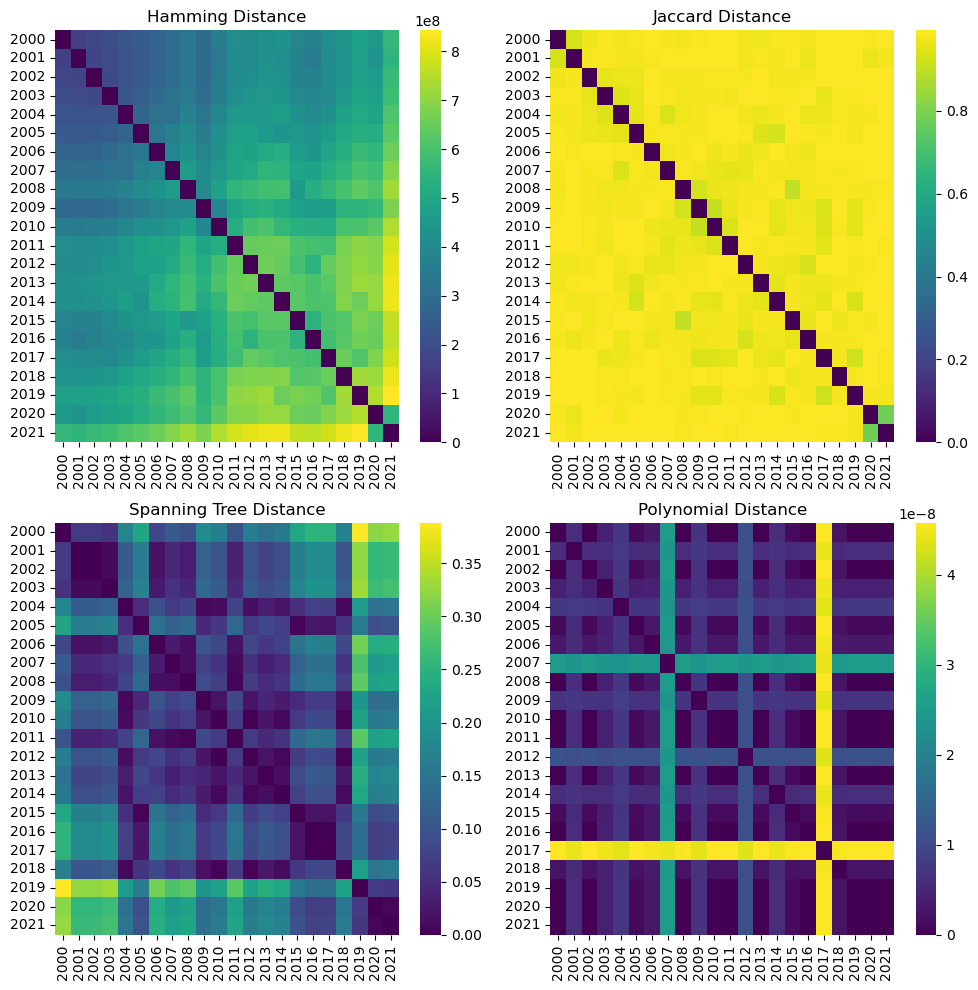

In [67]:
create_heatmaps(hamming_asia, jaccard_asia, st_asia, polynomial_asia)

### North America

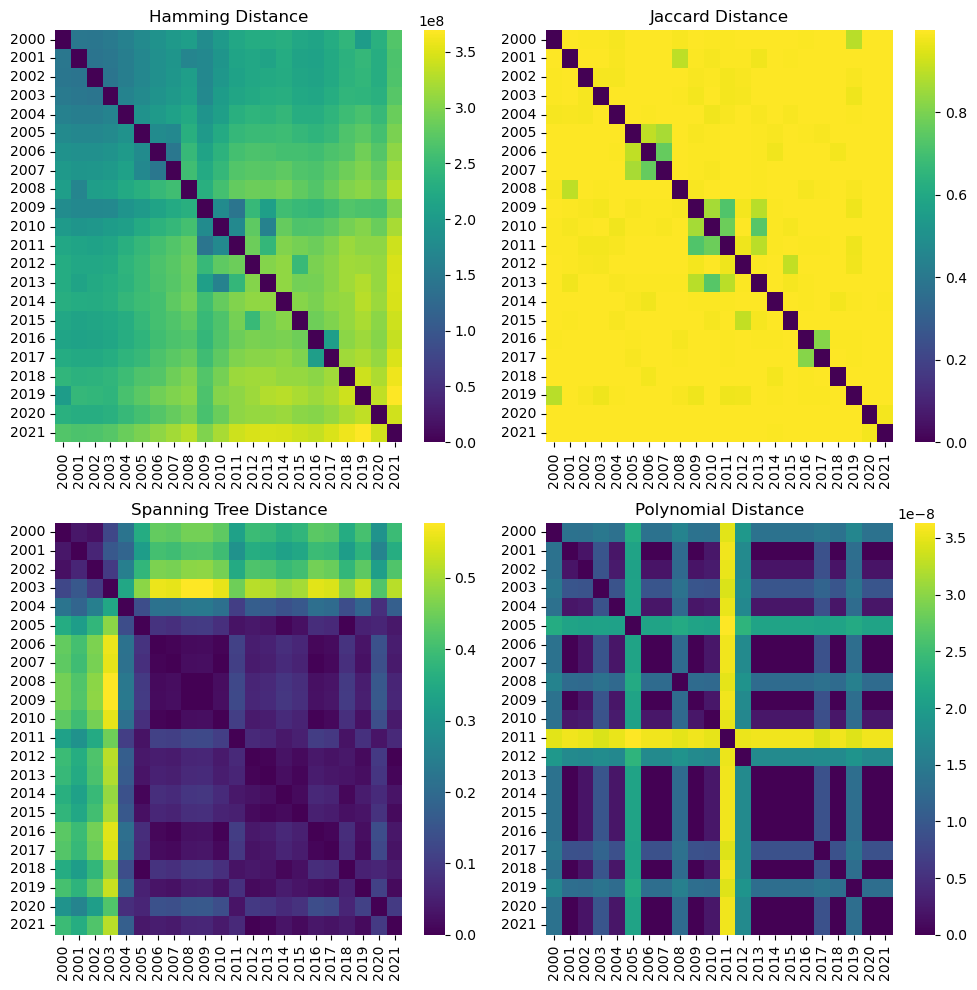

In [68]:
create_heatmaps(hamming_na, jaccard_na, st_na, polynomial_na)

### Europe

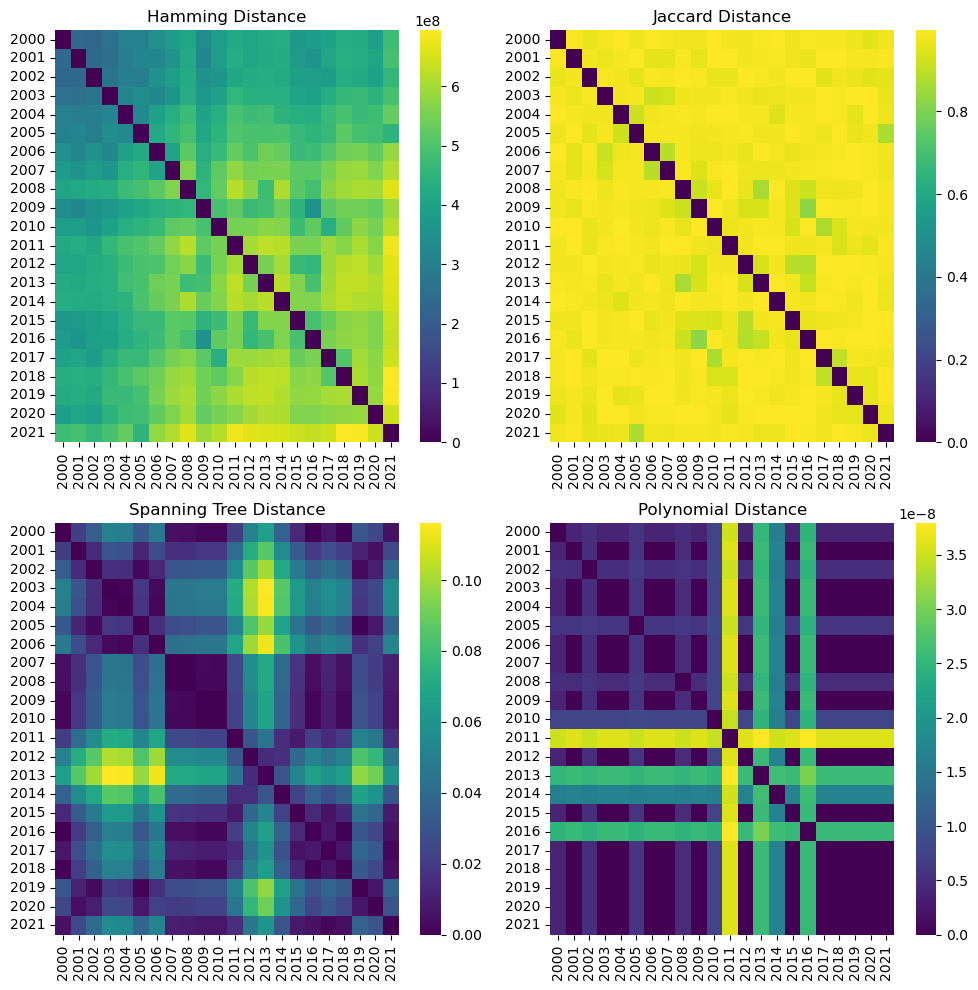

In [69]:
create_heatmaps(hamming_eur, jaccard_eur, st_eur, polynomial_eur)

### Hamming Distance Tests

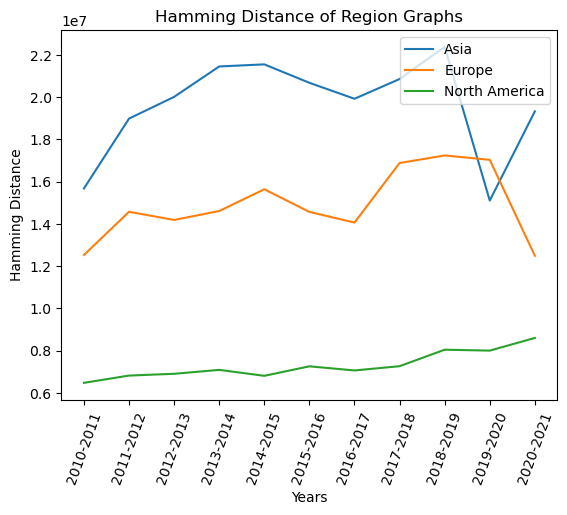

In [48]:
asia_dist, eur_dist, na_dist = consecutive_distances_regions(connected_graphs, hamming_distance)
dist_line_graph(asia_dist, eur_dist, na_dist, "Hamming Distance")

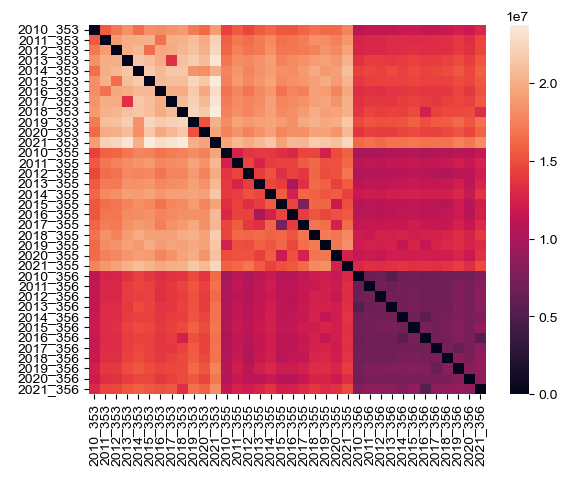

In [49]:
pairwise_heatmap(hamming_distances, h_labels)

/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


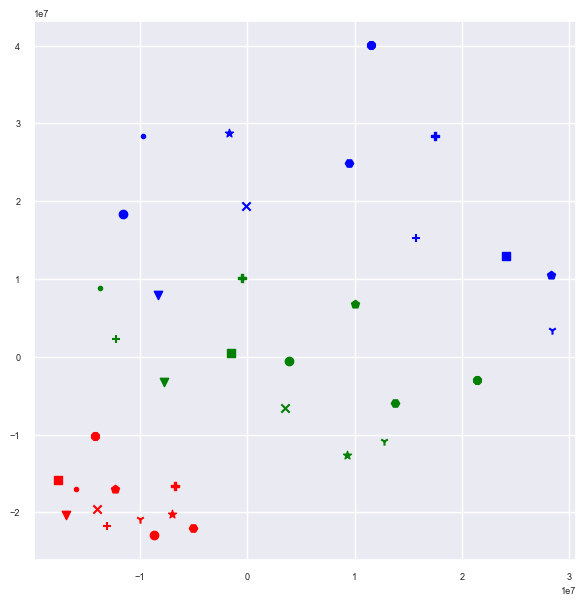

In [50]:
mds_projections(h_regions, hamming_distances)

In [51]:
observed_value, h_metagraph = get_metagraph(hamming_distances, h_labels, h_regions)
h_random_graphs = random_graphs(h_metagraph)
simulated_values = np.array(get_same_class_random(h_random_graphs))

In [52]:
significance_level = 0.05
simulations_as_or_more_extreme = sum(
    simulated_values >= observed_value
)

num_simulations = simulated_values.shape[0]
p_value = simulations_as_or_more_extreme / num_simulations

p_value

4e-05

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_73554/1984758911.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  density_plot = sns.kdeplot(simulated_values, shade=True)


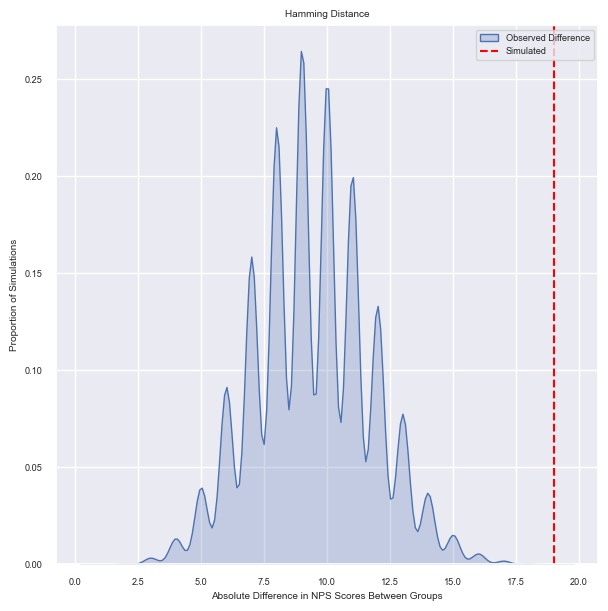

In [53]:
# Plot permutation simulations
density_plot = sns.kdeplot(simulated_values, shade=True)
density_plot.set(
    xlabel='Absolute Difference in NPS Scores Between Groups',
    ylabel='Proportion of Simulations',
    title = "Hamming Distance"
)

# Add a line to show the actual difference observed in the data
density_plot.axvline(
    x=observed_value, 
    color='red', 
    linestyle='--'
)

plt.legend(
    labels=['Observed Difference', 'Simulated'], 
    loc='upper right'
)
plt.show()

### Jaccard Tests

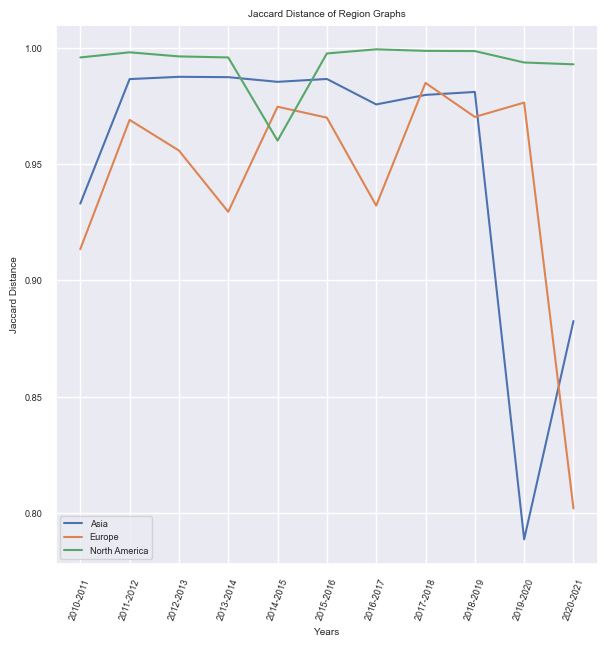

In [54]:
asia_dist, eur_dist, na_dist = consecutive_distances_regions(connected_graphs, jaccard_distance)
dist_line_graph(asia_dist, eur_dist, na_dist, "Jaccard Distance")

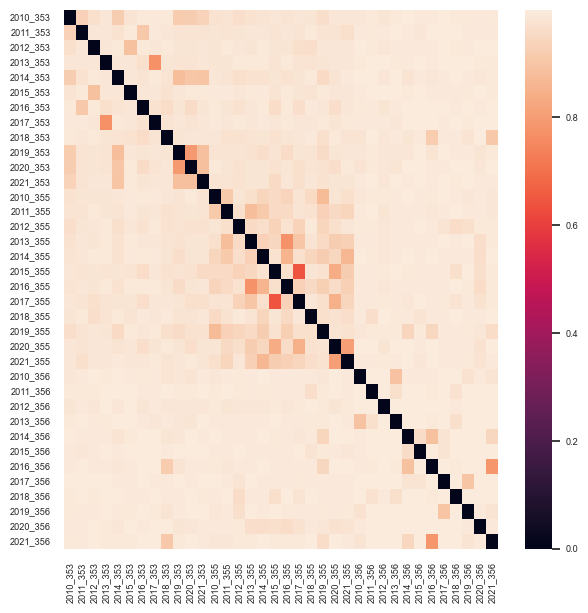

In [55]:
pairwise_heatmap(jaccard_distances, j_labels)

/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


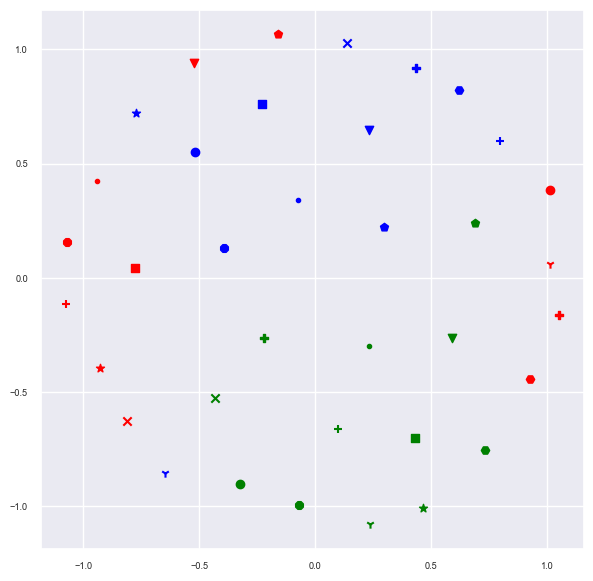

In [56]:
mds_projections(j_regions, jaccard_distances)

In [57]:
observed_value, j_metagraph = get_metagraph(jaccard_distances, j_labels, j_regions)
j_random_graphs = random_graphs(j_metagraph)
simulated_values = np.array(get_same_class_random(j_random_graphs))

In [58]:
significance_level = 0.05
simulations_as_or_more_extreme = sum(
    simulated_values >= observed_value
)

num_simulations = simulated_values.shape[0]
p_value = simulations_as_or_more_extreme / num_simulations

p_value

0.0

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_73554/3450051568.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  density_plot = sns.kdeplot(simulated_values, shade=True)


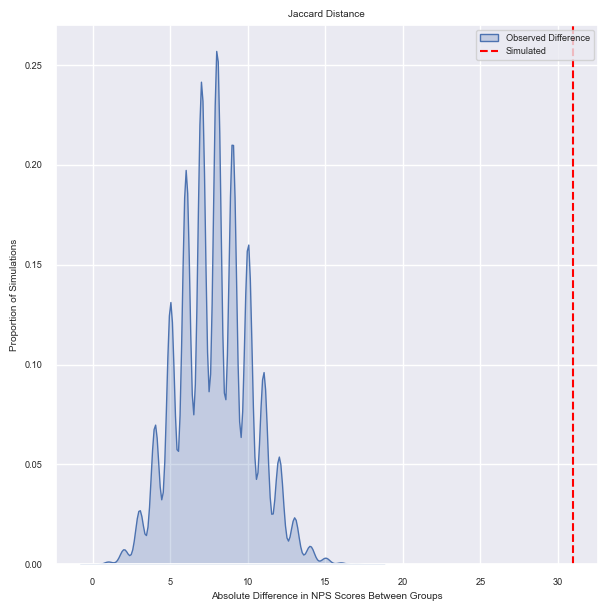

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot permutation simulations
density_plot = sns.kdeplot(simulated_values, shade=True)
density_plot.set(
    xlabel='Absolute Difference in NPS Scores Between Groups',
    ylabel='Proportion of Simulations',
    title = "Jaccard Distance"
)

# Add a line to show the actual difference observed in the data
density_plot.axvline(
    x=observed_value, 
    color='red', 
    linestyle='--'
)

plt.legend(
    labels=['Observed Difference', 'Simulated'], 
    loc='upper right'
)
plt.show()

### Spanning Tree Tests

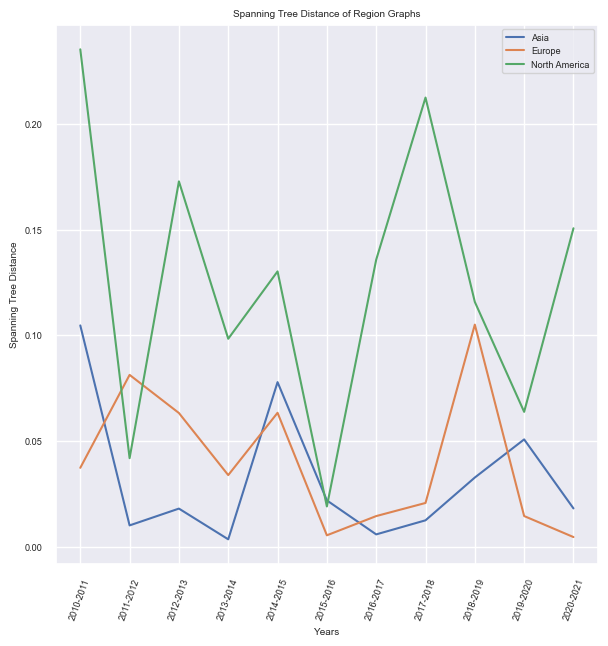

In [60]:
asia_dist, eur_dist, na_dist = consecutive_distances_regions(connected_graphs, st_distance)
dist_line_graph(asia_dist, eur_dist, na_dist, "Spanning Tree Distance")

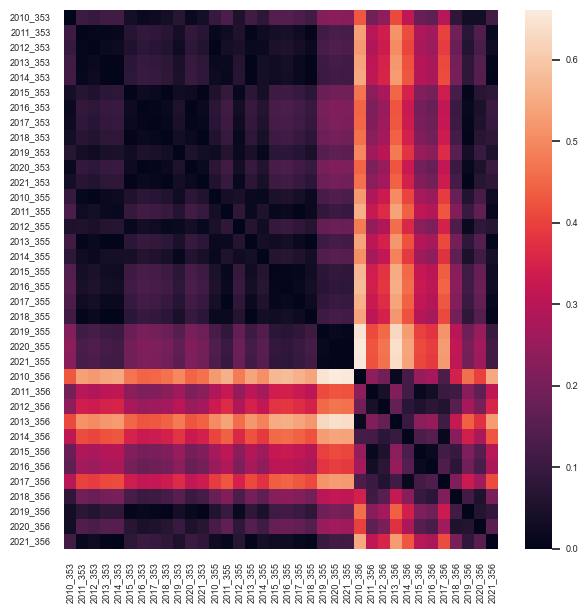

In [61]:
pairwise_heatmap(st_distances, st_labels)

/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


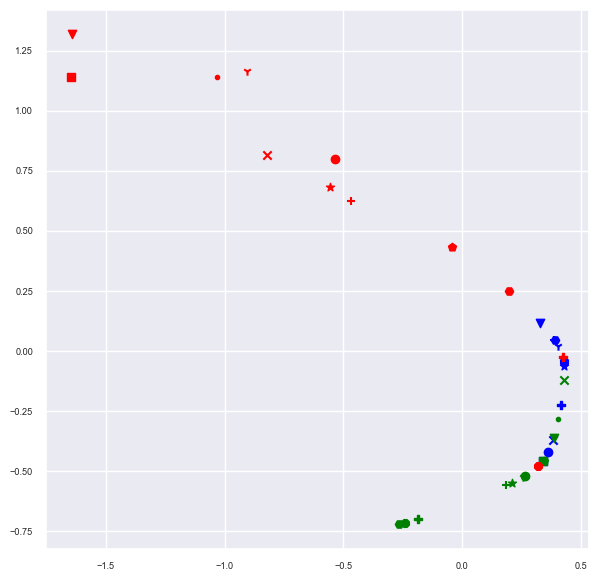

In [62]:
mds_projections(st_regions, st_distances)

In [63]:
observed_value, st_metagraph = get_metagraph(st_distances, st_labels, st_regions)
st_random_graphs = random_graphs(st_metagraph)
simulated_values = np.array(get_same_class_random(st_random_graphs))

In [64]:
significance_level = 0.05
simulations_as_or_more_extreme = sum(
    simulated_values >= observed_value
)

num_simulations = simulated_values.shape[0]
p_value = simulations_as_or_more_extreme / num_simulations

p_value

0.0

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_73554/2327888341.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  density_plot = sns.kdeplot(simulated_values, shade=True)


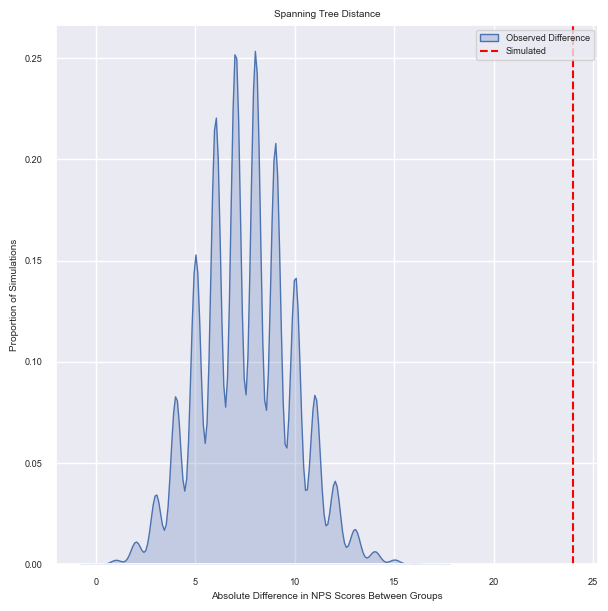

In [65]:
# Plot permutation simulations
density_plot = sns.kdeplot(simulated_values, shade=True)
density_plot.set(
    xlabel='Absolute Difference in NPS Scores Between Groups',
    ylabel='Proportion of Simulations',
    title = "Spanning Tree Distance"
)

# Add a line to show the actual difference observed in the data
density_plot.axvline(
    x=observed_value, 
    color='red', 
    linestyle='--'
)

plt.legend(
    labels=['Observed Difference', 'Simulated'], 
    loc='upper right'
)
plt.show()

### Polynomial Tests

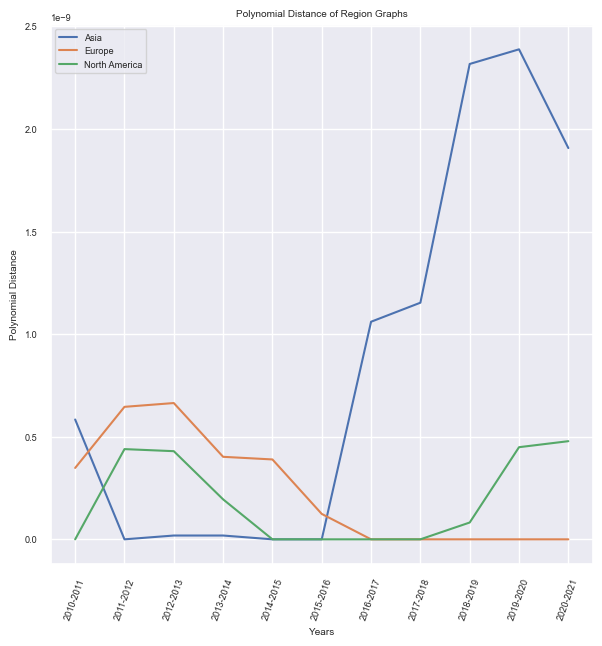

In [66]:
asia_dist, eur_dist, na_dist = consecutive_distances_regions(connected_graphs, polynomial_distance)
dist_line_graph(asia_dist, eur_dist, na_dist, "Polynomial Distance")

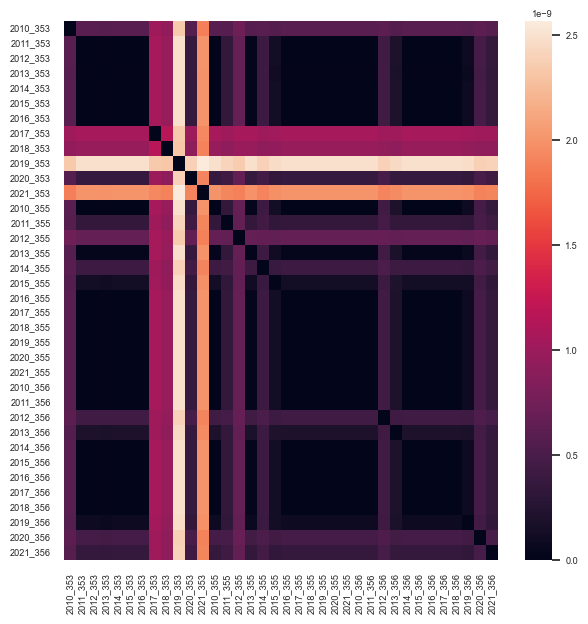

In [67]:
pairwise_heatmap(polynomial_distances, p_labels)

/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


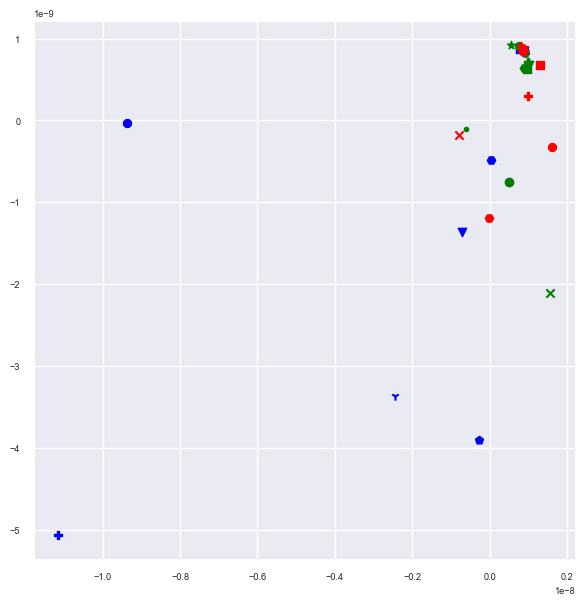

In [68]:
mds_projections(p_regions, polynomial_distances)

In [69]:
observed_value, p_metagraph = get_metagraph(polynomial_distances, p_labels, p_regions)
p_random_graphs = random_graphs(p_metagraph)
simulated_values = np.array(get_same_class_random(p_random_graphs))

In [70]:
significance_level = 0.05
simulations_as_or_more_extreme = sum(
    simulated_values >= observed_value
)

num_simulations = simulated_values.shape[0]
p_value = simulations_as_or_more_extreme / num_simulations

p_value

0.0304

/var/folders/qh/0wyfgfcs3399gr_m2wrrtnzc0000gn/T/ipykernel_73554/2133693105.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  density_plot = sns.kdeplot(simulated_values, shade=True)


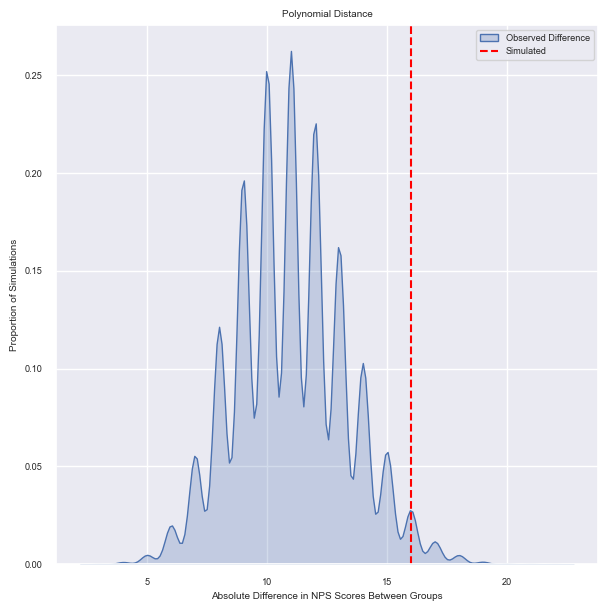

In [71]:
# Plot permutation simulations
density_plot = sns.kdeplot(simulated_values, shade=True)
density_plot.set(
    xlabel='Absolute Difference in NPS Scores Between Groups',
    ylabel='Proportion of Simulations',
    title = "Polynomial Distance"
)

# Add a line to show the actual difference observed in the data
density_plot.axvline(
    x=observed_value, 
    color='red', 
    linestyle='--'
)

plt.legend(
    labels=['Observed Difference', 'Simulated'], 
    loc='upper right'
)
plt.show()

### Agglomerative Clustering

In [73]:
hamming_distances, h_labels, h_years, h_regions = pairwise_distance(connected_graphs, hamming_distance)
jaccard_distances, j_labels, j_years, j_regions = pairwise_distance(connected_graphs, jaccard_distance)
st_distances, st_labels, st_years, st_regions = pairwise_distance(connected_graphs, st_distance)
polynomial_distances, p_labels, p_years, p_regions = pairwise_distance(updated_graphs, polynomial_distance)

In [78]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score

clustering = AgglomerativeClustering(n_clusters=3).fit(hamming_distances)
cluster_labels = clustering.labels_
print(normalized_mutual_info_score(cluster_labels, true_region_labels))
print(homogeneity_score(true_region_labels, cluster_labels))
print(completeness_score(true_region_labels, cluster_labels))

0.9118224674289612
0.910860731460241
0.9127862364498732


/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [79]:
clustering = AgglomerativeClustering(n_clusters=3).fit(jaccard_distances)
cluster_labels = clustering.labels_
print(normalized_mutual_info_score(cluster_labels, true_region_labels))
print(homogeneity_score(true_region_labels, cluster_labels))
print(completeness_score(true_region_labels, cluster_labels))

0.5558660569075122
0.5168544751277218
0.6012475294365334


/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [80]:
clustering = AgglomerativeClustering(n_clusters=3).fit(st_distances)
cluster_labels = clustering.labels_
print(normalized_mutual_info_score(cluster_labels, true_region_labels))
print(homogeneity_score(true_region_labels, cluster_labels))
print(completeness_score(true_region_labels, cluster_labels))

0.4225865291307521
0.41339558760988837
0.4321954441056933


/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [81]:
clustering = AgglomerativeClustering(n_clusters=3).fit(polynomial_distances)
cluster_labels = clustering.labels_
print(normalized_mutual_info_score(cluster_labels, true_region_labels))
print(homogeneity_score(true_region_labels, cluster_labels))
print(completeness_score(true_region_labels, cluster_labels))

0.07921906414917686
0.06797337638782286
0.09492343853386907


/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
